# Traffic Incident Management in Nashville, TN

### Loading the libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import math
import sys
import re

from shapely.geometry import Point
from shapely.geometry import LineString
import geopandas as gpd
import descartes
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

%matplotlib inline

### Importing the data

In [2]:
traffic_df = pd.read_csv('../data/MASTER File 2021.csv')
d_weather = pd.read_csv('../data/Daily Weather Formatted.csv')
h_weather = pd.read_csv('../data/Hourly Weather Formatted.csv')

C:\Users\suzan\anaconda3\envs\geospatial\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Reviewing the Traffic Dataframe

In [3]:
print(traffic_df.shape)

(33730, 27)


In [4]:
traffic_df.head(2)

,Region,Incident ID,Incident Type,Full Location,Start Date,Start Time,Duration ICT,Lanes Blocked,Blockage Duration RCT,Response Time,...,Description,Inc MM,Latitude,Longitude,Severity Lanes,Severity Duration,Severity,Temp,Prec,Condition
0,3,726,MultiVehicle Crash,"DAVIDSON on Interstate 40 Westbound, Beyond MI...",11/12/2020,10:25:06 AM,100,0,0,0,...,MILE MARKER 213.2,213.2,36.140377,-86.723936,Level 1,Level 1,Level 1,55.0,0.0,Clear
1,3,728,Disabled Vehicle,"DAVIDSON on Interstate 65 Northbound, Before M...",11/12/2020,10:35:05 AM,102.3666667,0,0,0.066666667,...,MILE MARKER 80.6,80.6,36.122863,-86.773113,Level 1,Level 1,Level 1,55.0,0.0,Clear


In [5]:
traffic_df['Start Date'].value_counts()

7/9/2021      146
4/7/2021      145
3/2/2021      141
7/29/2021     140
2/22/2021     140
             ... 
3/14/2021      51
9/12/2021      50
5/29/2021      46
12/27/2020     41
1/24/2021      31
Name: Start Date, Length: 365, dtype: int64

### Converting the datetime data type from object to datetime64 in traffic dataframe

In [6]:
traffic_df['Start Date'] = pd.to_datetime(traffic_df['Start Date'])

In [7]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33730 entries, 0 to 33729
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Region                 33730 non-null  int64         
 1   Incident ID            33730 non-null  int64         
 2   Incident Type          33730 non-null  object        
 3   Full Location          33730 non-null  object        
 4   Start Date             33730 non-null  datetime64[ns]
 5   Start Time             33730 non-null  object        
 6   Duration ICT           33730 non-null  object        
 7   Lanes Blocked          33730 non-null  int64         
 8   Blockage Duration RCT  33730 non-null  object        
 9   Response Time          33730 non-null  object        
 10  Rural/
Urban           33730 non-null  object        
 11  Key                    33730 non-null  int64         
 12  County                 33730 non-null  object        
 13  I

In [8]:
d_weather.head(1)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,sealevelpressure,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations
0,nashville tennessee,2020-11-01,61.6,41.6,54.5,61.6,36.6,53.5,34.1,49.95,...,1025.2,22.4,9.9,2020-11-01T06:10:26,2020-11-01T16:50:26,0.51,Clear,Partly cloudy throughout the day.,Clear,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827"


### Converting the datetime data type from object to datetime64 in daily weather dataframe 

In [9]:
d_weather['datetime'] = pd.to_datetime(d_weather['datetime'])

### Merging traffic and weather dataframe

In [10]:
traffic_df = pd.merge(traffic_df, d_weather, left_on = 'Start Date', right_on = 'datetime', how = 'inner')

In [11]:
traffic_df.head()

,Region,Incident ID,Incident Type,Full Location,Start Date,Start Time,Duration ICT,Lanes Blocked,Blockage Duration RCT,Response Time,...,sealevelpressure,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations
0,3,726,MultiVehicle Crash,"DAVIDSON on Interstate 40 Westbound, Beyond MI...",2020-11-12,10:25:06 AM,100,0,0,0,...,1017.7,5.1,9.9,2020-11-12T06:21:29,2020-11-12T16:40:48,0.95,Clear,Clear conditions throughout the day.,Clear,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827"
1,3,728,Disabled Vehicle,"DAVIDSON on Interstate 65 Northbound, Before M...",2020-11-12,10:35:05 AM,102.3666667,0,0,0.066666667,...,1017.7,5.1,9.9,2020-11-12T06:21:29,2020-11-12T16:40:48,0.95,Clear,Clear conditions throughout the day.,Clear,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827"
2,3,732,Abandoned Vehicle,"DAVIDSON on Interstate 24 Eastbound, Before MI...",2020-11-12,10:59:43 AM,"1,690",0,0,0,...,1017.7,5.1,9.9,2020-11-12T06:21:29,2020-11-12T16:40:48,0.95,Clear,Clear conditions throughout the day.,Clear,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827"
3,3,735,Disabled Vehicle,"RUTHERFORD on Interstate 24 Eastbound, Before ...",2020-11-12,11:04:04 AM,55,0,0,0,...,1017.7,5.1,9.9,2020-11-12T06:21:29,2020-11-12T16:40:48,0.95,Clear,Clear conditions throughout the day.,Clear,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827"
4,3,736,Abandoned Vehicle,"DAVIDSON on Interstate 40 Westbound, Before MI...",2020-11-12,11:05:09 AM,"1,224",1,12,0,...,1017.7,5.1,9.9,2020-11-12T06:21:29,2020-11-12T16:40:48,0.95,Clear,Clear conditions throughout the day.,Clear,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827"


In [68]:
rain_df = traffic_df.loc[traffic_df.conditions =='Rain']

In [71]:
rain_df.head(2)

,Region,Incident ID,Incident Type,Full Location,Start Date,Start Time,Duration ICT,Lanes Blocked,Blockage Duration RCT,Response Time,...,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations,geometry
240,3,1002,MultiVehicle Crash,"WILLIAMSON on Interstate 65 Southbound, Beyond...",2020-11-15,2:56:20 AM,29.26666667,0,0,0,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.0,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.84721 35.80975)
241,3,1003,Disabled Vehicle,"DAVIDSON on Interstate 65 Northbound, Before M...",2020-11-15,3:32:54 AM,83.18333333,0,0,0,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.0,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.70276 36.31016)


In [73]:
snow_df = traffic_df.loc[traffic_df.conditions == 'Snow']

In [75]:
snow_df.head(2)

,Region,Incident ID,Incident Type,Full Location,Start Date,Start Time,Duration ICT,Lanes Blocked,Blockage Duration RCT,Response Time,...,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations,geometry
4843,3,7006,Disabled Vehicle,"DAVIDSON on Interstate 24 Eastbound, Before MI...",2021-01-11,12:32:28 AM,"2,542",0,0,418,...,94.7,7.5,2021-01-11T06:58:19,2021-01-11T16:52:24,0.99,Snow,Cloudy skies throughout the day with late afte...,Snow,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.68727 36.06725)
4844,3,7007,Disabled Vehicle,"DAVIDSON on Interstate 65 Northbound, Before M...",2021-01-11,12:36:08 AM,39.36666667,0,0,8.8,...,94.7,7.5,2021-01-11T06:58:19,2021-01-11T16:52:24,0.99,Snow,Cloudy skies throughout the day with late afte...,Snow,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.77619 36.20802)


In [79]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33730 entries, 0 to 33729
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Region                 33730 non-null  int64         
 1   Incident ID            33730 non-null  int64         
 2   Incident Type          33730 non-null  object        
 3   Full Location          33730 non-null  object        
 4   Start Date             33730 non-null  datetime64[ns]
 5   Start Time             33730 non-null  object        
 6   Duration ICT           33730 non-null  object        
 7   Lanes Blocked          33730 non-null  int64         
 8   Blockage Duration RCT  33730 non-null  object        
 9   Response Time          33730 non-null  object        
 10  Rural/
Urban           33730 non-null  object        
 11  Key                    33730 non-null  int64         
 12  County                 33730 non-null  object        
 13  I

In [85]:
multivehicle_rain_df = traffic_df.loc[(traffic_df['Incident Type'] == 'MultiVehicle Crash') & (traffic_df['conditions'] == 'Rain')]

In [86]:
multivehicle_rain_df

,Region,Incident ID,Incident Type,Full Location,Start Date,Start Time,Duration ICT,Lanes Blocked,Blockage Duration RCT,Response Time,...,cloudcover,visibility,sunrise,sunset,moonphase,conditions,description,icon,stations,geometry
240,3,1002,MultiVehicle Crash,"WILLIAMSON on Interstate 65 Southbound, Beyond...",2020-11-15,2:56:20 AM,29.26666667,0,0,0,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.00,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.84721 35.80975)
244,3,1010,MultiVehicle Crash,"DAVIDSON on Interstate 40 Westbound, Beyond MI...",2020-11-15,6:46:25 AM,54,1,10,2,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.00,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.69490 36.14434)
246,3,1012,MultiVehicle Crash,"DAVIDSON on Interstate 40 Westbound, Before MI...",2020-11-15,6:54:25 AM,54,2,52,-17,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.00,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-87.75084 36.15117)
247,3,1013,MultiVehicle Crash,"DAVIDSON on Interstate 24 Eastbound, Beyond MI...",2020-11-15,6:58:18 AM,16,1,14,2,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.00,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.65902 36.04535)
248,3,1014,MultiVehicle Crash,"DAVIDSON on Interstate 24 Eastbound, Before MI...",2020-11-15,7:02:54 AM,87,2,52,-18,...,43.6,9.7,2020-11-15T06:24:32,2020-11-15T16:38:44,0.00,Rain,Clearing in the afternoon with rain clearing l...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.72762 36.12854)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33643,3,106512,MultiVehicle Crash,"GILES on Interstate 65 Southbound, Beyond MILE...",2021-10-30,8:41:07 PM,481.5666667,1,480.55,0,...,97.5,7.6,2021-10-30T07:08:14,2021-10-30T17:52:46,0.84,Rain,Cloudy skies throughout the day with rain in t...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.87966 35.00743)
33644,3,106513,MultiVehicle Crash,"DAVIDSON on Interstate 65 Southbound, At EXIT ...",2021-10-30,8:53:17 PM,30.4,0,28.066667,1.65,...,97.5,7.6,2021-10-30T07:08:14,2021-10-30T17:52:46,0.84,Rain,Cloudy skies throughout the day with rain in t...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.77233 36.11295)
33645,3,106514,MultiVehicle Crash,"DAVIDSON on Interstate 24 Westbound, Beyond MI...",2021-10-30,9:44:55 PM,72,0,0.0,0,...,97.5,7.6,2021-10-30T07:08:14,2021-10-30T17:52:46,0.84,Rain,Cloudy skies throughout the day with rain in t...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.76468 36.16627)
33646,3,106515,MultiVehicle Crash,"DAVIDSON on Interstate 65 Southbound, Before M...",2021-10-30,10:03:31 PM,68.36666667,2,15.766667,3.65,...,97.5,7.6,2021-10-30T07:08:14,2021-10-30T17:52:46,0.84,Rain,Cloudy skies throughout the day with rain in t...,Rain,"72327013897,KJWN,KBNA,KMQY,KM91,72327313827",POINT (-86.77762 36.04651)


### Reviewing Traffic Columns

In [12]:
traffic_df.columns

Index(['Region', 'Incident ID', 'Incident Type', 'Full Location ',
       'Start Date', 'Start Time', 'Duration ICT', 'Lanes Blocked',
       'Blockage Duration RCT', 'Response Time', 'Rural/\nUrban', 'Key ',
       'County', 'Interstate', 'Route', 'Direction', 'Unnamed: 16',
       'Description', 'Inc MM', 'Latitude', 'Longitude', 'Severity Lanes',
       'Severity Duration', 'Severity', 'Temp', 'Prec', 'Condition', 'name',
       'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

### Calculating the frequencies in the dataset

In [13]:
incidents = traffic_df['Incident Type'].value_counts().reset_index()
incidents.columns = ['Incident Type', 'Count']

In [14]:
#calculate the max amount of incidents
incidents_max = incidents['Incident Type'].iloc[incidents['Count'].idxmax()]

In [15]:
#printing out the max amount of incidents
print('The ' + str(incidents_max) + ' has the most incidents in the dataset.')

The Disabled Vehicle has the most incidents in the dataset.


In [16]:
#view the dataframe
incidents.head(1)

,Incident Type,Count
0,Disabled Vehicle,19210


In [17]:
#spot check
traffic_df['Incident Type'].value_counts()
#traffic_df['Incident Type'].isnull().value_counts()
#traffic_df['Incident Type'].unique()

Disabled Vehicle              19210
MultiVehicle Crash             5493
Abandoned Vehicle              4841
Debris on Roadway              1908
Single Vehicle Crash           1216
PD/Med/Fire Activity            376
Overturned Vehicle              271
Vehicle Fire                    190
Weather                          54
Flooding                         36
Special Event                    35
Jack-Knife Tractor Trailer       33
Other                            28
Off Ramp Backup                  22
Interstate Shooting              13
Oversize Load                     2
Wrong Way Driver                  2
Name: Incident Type, dtype: int64

In [18]:
countys = traffic_df['County'].value_counts().reset_index()
countys.columns = ['County', 'Count']

In [19]:
countys.head(1)

,County,Count
0,DAVIDSON,28129


In [20]:
conditions = traffic_df['conditions'].value_counts().reset_index()
conditions.columns = ['Conditions', 'Count']

In [21]:
conditions_max = conditions['Conditions'].iloc[conditions['Count'].idxmax()]

In [22]:
conditions.head()

,Conditions,Count
0,Clear,20272
1,Rain,12754
2,Snow,704


In [23]:
conditions_max

'Clear'

In [24]:
#printing out the max amount of conditions
print('The ' + str(conditions_max) + ' condition has the greatest amount of incidents in the dataset.')

The Clear condition has the greatest amount of incidents in the dataset.


In [25]:
#davidson = traffic_df[traffic_df['County']=='Davidson']

In [26]:
#Extracting just the digits and the decimal place
#gourds['weight'] = gourds['weight'].str.extract('(\d*.\d*)')

#Making sure it's a float
#gourds['weight'] = gourds['weight'].astype('float64')

#Sorting based on weight column
#gourds = gourds.sort_values(by = 'weight', ascending = False).reset_index(drop = True)

### geospatial coding. update 'geometry' column

In [27]:
#traffic_df['geometry'] = traffic_df.apply(lambda x: Point((float(x.Longitude),
 #                                                  float(x.Latitude))),
  #                                axis=1)

In [28]:
#traffic_geo = gpd.GeoDataFrame(traffic_df)

In [29]:
#traffic_geo.head()

In [30]:
#type(traffic_geo)

### Save the number of rows and columns as a tuple

In [31]:
#rows_and_cols = traffic_df.shape
#print('There are {} rows and {} columns.\n'.format(
  #  rows_and_cols[0], rows_and_cols[1]))

In [32]:
# compile the list of dataframes to be merged
#data_frames = [car_accident0, car_accident1, car_accident2,car_accident3, car_accident4]

In [33]:
#traffic_2021 = pd.concat([traffic_df, h_weather, d_weather], sort=True)
#traffic_2021.head(2)

In [34]:
#The amount in brackets will populate. 
#print('There are {} accidents in the data'.format(len(car_accidents_2010_2020)))

In [35]:
#dropping columns, all columns listed to have as a visual
#pd.set_option('display.max_columns', 1000)
#df.drop(['Region', 'Incident ID', 'Incident Type', 'Full Location ',
#       'Start Date', 'Start Time', 'Duration ICT', 'Lanes Blocked RCT',
#       'Blockage\nDuration', 'Resp Time', 'Rural/\nUrban', 'Key ', 'County',
#       'Interstate', 'Route', 'Direction', 'Unnamed: 16', 'Description',
#       'Inc MM', 'Latitude', 'Longitude', 'Severity Lanes',
#       'Severity Duration', 'Severity'], axis=1, inplace=True)
#df.tail()

### Top _ sorted & Column rename

In [36]:
#gdp_and_internet_use_2014.sort_values(by = 'Internet_Users_Pct', ascending = False).head()

In [37]:
#d_weather = d_weather.rename(columns = {'Start Date':'Start_Date'})

In [38]:
#traffic_df['Start Date'] = traffic_df['Start Date'].astype('str')

### Date/Time

In [39]:
#car_accidents_2010_2020['DateTime'] = pd.to_datetime(car_accidents_2010_2020['Date and Time'])
#car_accidents_2010_2020['date'] = car_accidents_2010_2020['DateTime'].dt.date
#car_accidents_2010_2020['time'] = car_accidents_2010_2020['DateTime'].dt.time

In [40]:
#car_accidents_2010_2020 = car_accidents_2010_2020.set_index('DateTime')
#car_accidents_2010_2020.head(3)

### Bar Chart

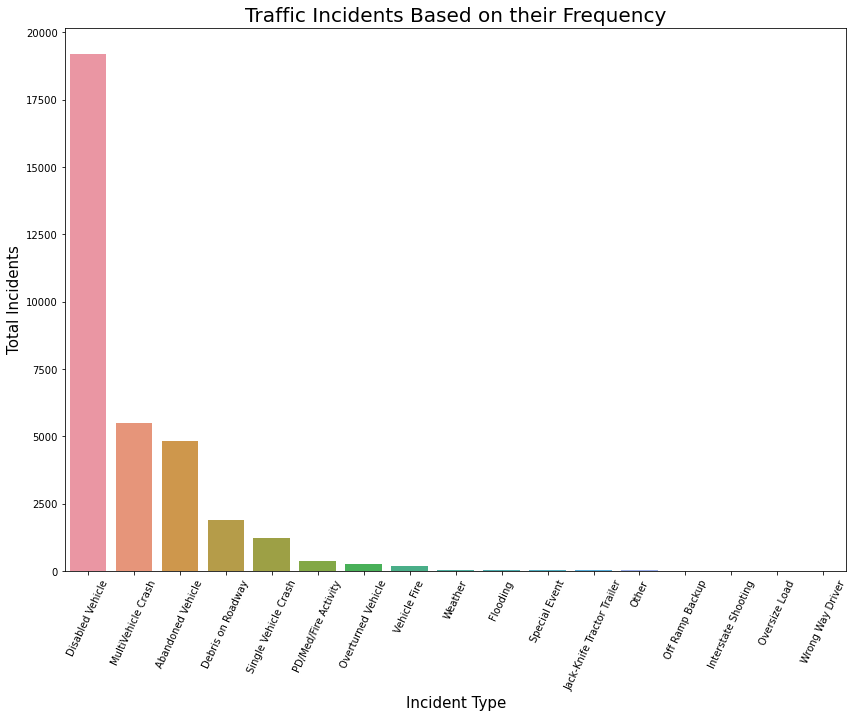

In [41]:
#plotting the greatest frequency of incidents
plt.figure(figsize = (14,10))
sns.barplot(x = 'Incident Type', y = 'Count', data = incidents)
plt.xticks(rotation=65, horizontalalignment='center')
plt.xlabel('Incident Type', fontsize = 15)
plt.ylabel('Total Incidents', fontsize = 15)
plt.title('Traffic Incidents Based on their Frequency', fontsize = 20);

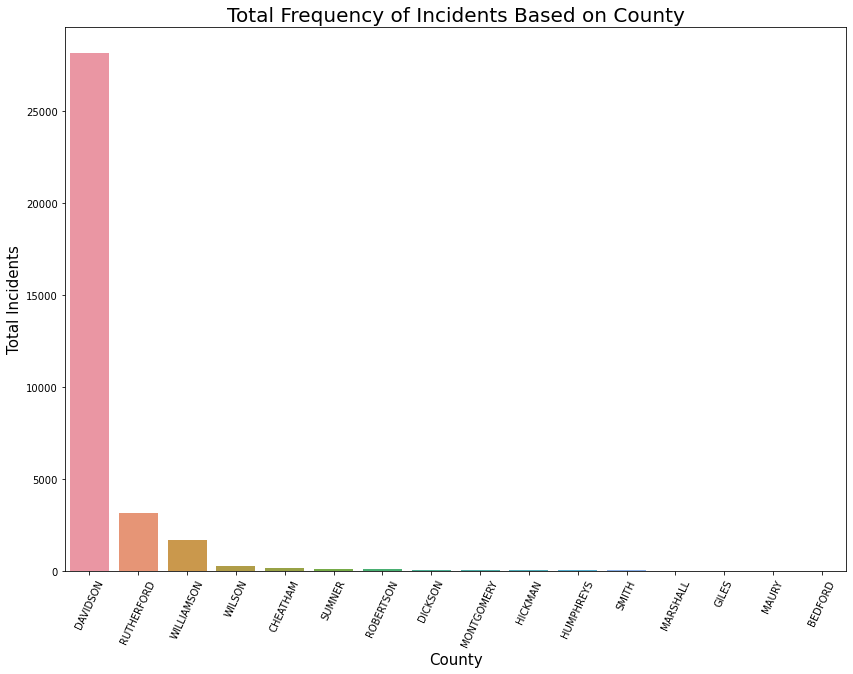

In [42]:
#plotting the greatest frequency of incidents per county
plt.figure(figsize = (14,10))
sns.barplot(x = 'County', y = 'Count', data = countys)
plt.xticks(rotation=65, horizontalalignment='center')
plt.xlabel('County', fontsize = 15)
plt.ylabel('Total Incidents', fontsize = 15)
plt.title('Total Frequency of Incidents Based on County', fontsize = 20);

### Histographs

In [43]:
#traffic_df['column name'].value_counts()

In [44]:
#traffic_df['number_of_motor_vehicles'] = pd.to_numeric(traffic_df['number_of_motor_vehicles'])  
                                                                        
#traffic_df.hist(['number_of_motor_vehicles'])

In [45]:
#car_accidents_2010_2020['Collision Type'].value_counts(normalize=True).sort_index().plot.bar()
#plt.grid()
#plt.title('collision Type')
#plt.xlabel('Collision Type')
#plt.ylabel('Fraction');

In [46]:
#car_accidents_2010_2020['Collision Type'].value_counts().plot.bar()
#plt.grid()
#plt.title('collision Type')
#plt.xlabel('Collision Type')
#plt.ylabel('Fraction');

In [47]:
#car_accidents_2010_2020['Collision Type Description'].value_counts(normalize=True).sort_index().plot.bar()
#plt.grid()
#plt.title('Collision Type Description')
#plt.xlabel('Collision Type Description')
#plt.ylabel('Fraction');

In [48]:
#car_accidents_2010_2020['Collision Type Description'].value_counts().plot.bar()
#plt.grid()
#plt.title('Collision Type Description')
#plt.xlabel('Collision Type Description')
#plt.ylabel('Total count');

In [49]:
#car_accidents_2010_2020['Weekday'] = car_accidents_2010_2020.index.weekday_name
#weekday = car_accidents_2010_2020.groupby('Weekday')['Accident Number'].count()
#weekday = weekday/weekday.sum()
#dayOfWeek=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#weekday[dayOfWeek].plot.bar()
#plt.title('Acccidents by Weekday')
#plt.xlabel('Weekday')
#plt.ylabel('Accidents');

In [50]:
#years = ['2010','2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019']
#fig, _ = plt.subplots(1,10,figsize=(21,7), sharex='all', sharey='all')

#fig.suptitle('Acccidents by Weekday for Different Years')
#plt.xlabel('Weekday')
#plt.ylabel('Accidents')
#for i, year in enumerate(years,1):
   # weekday = car_accidents_2010_2020.loc[year].groupby('Weekday')['Accident Number'].count()
  #  weekday = weekday/weekday.sum()
  #  dayOfWeek=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  #  plt.subplot(1,10,i)
  #  plt.title(year)
  #  weekday[dayOfWeek].plot.bar()

### Maps and Scatterplots

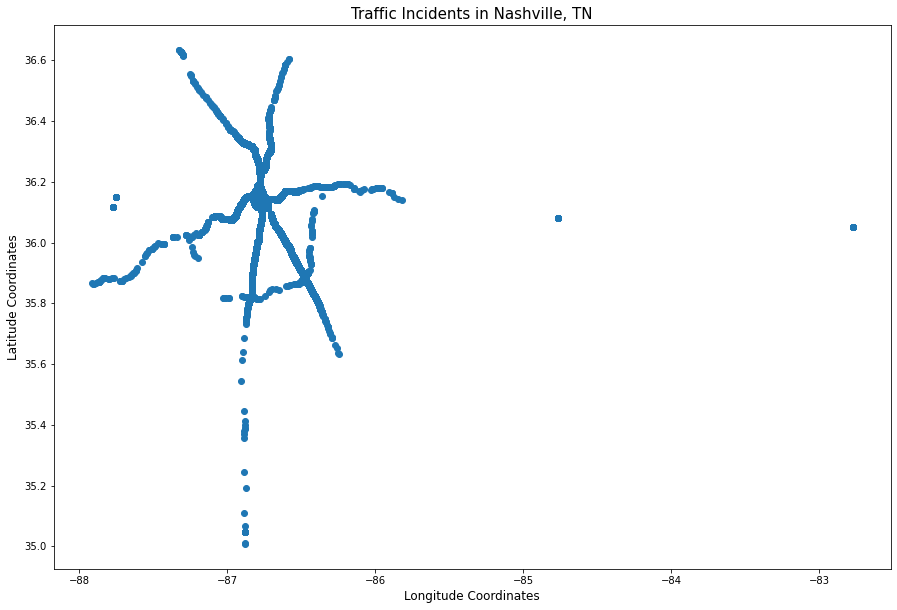

In [51]:
plt.figure(figsize = (15,10))
plt.scatter(x=traffic_df['Longitude'], y=traffic_df['Latitude'])
plt.title('Traffic Incidents in Nashville, TN', fontsize = 15)
plt.xlabel('Longitude Coordinates', fontsize = 12)
plt.ylabel('Latitude Coordinates', fontsize = 12)
plt.show()

<AxesSubplot:>

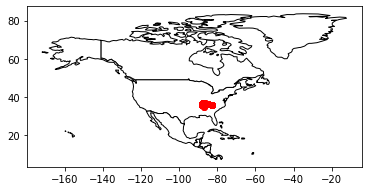

In [52]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

#traffic_df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(traffic_df['Longitude'], traffic_df['Latitude'])]
gdf = GeoDataFrame(traffic_df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')
#ax = gdf.plot(figsize = (10, 6), color = 'red')
gdf.plot(ax=ax, color='red', marker='o')
#code for the world below
#gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [53]:
#center = traffic_df.geometry.centroid[-86.77676762, 36.2324525740]

In [54]:
#center.y = 36.2324525740

In [55]:
#center.x = -86.77676762

In [56]:
area_center = [36.2324525740, -86.77676762]

In [57]:
print(area_center)

[36.232452574, -86.77676762]


In [60]:
#only run if needed
#nash_map = folium.Map(location = area_center, zoom_start = 12)

#for row_index, row_values in traffic_df.iterrows():
#    loc = [row_values['Latitude'], row_values['Longitude']]
 #   pop = str(row_values['County'])
#    icon = folium.Icon(color = "red", icon ="traffic", prefix='fa')
    
   # marker = folium.Marker(
  #      location = loc, 
  #      popup = pop, icon = icon) 

 #   marker.add_to(nash_map)
#nash_map.save('../data/nash_map.html')


In [ ]:
#nash_map

In [62]:
cluster_map_nash = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_nash)

folium.GeoJson(traffic_df).add_to(cluster_map_nash)

# inside the loop add each marker to the cluster
for row_index, row_values in traffic_df.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['County'])
    icon=folium.Icon(color = "blue", icon ="traffic", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_nash.save('../data/cluster_map_nash.html')

ValueError: Cannot render objects with any missing geometries:        Region  Incident ID         Incident Type  \
0           3          726    MultiVehicle Crash   
1           3          728      Disabled Vehicle   
2           3          732     Abandoned Vehicle   
3           3          735      Disabled Vehicle   
4           3          736     Abandoned Vehicle   
...       ...          ...                   ...   
33725       3       106619    MultiVehicle Crash   
33726       3       106622    MultiVehicle Crash   
33727       3       106623    MultiVehicle Crash   
33728       3       106624  Single Vehicle Crash   
33729       3       106625    MultiVehicle Crash   

                                          Full Location  Start Date  \
0      DAVIDSON on Interstate 40 Westbound, Beyond MI... 2020-11-12   
1      DAVIDSON on Interstate 65 Northbound, Before M... 2020-11-12   
2      DAVIDSON on Interstate 24 Eastbound, Before MI... 2020-11-12   
3      RUTHERFORD on Interstate 24 Eastbound, Before ... 2020-11-12   
4      DAVIDSON on Interstate 40 Westbound, Before MI... 2020-11-12   
...                                                  ...        ...   
33725  DAVIDSON on Interstate 65 Northbound, Before M... 2021-10-31   
33726  DAVIDSON on Interstate 24 Eastbound, Before MI... 2021-10-31   
33727  DAVIDSON on Interstate 40 Eastbound, Before MI... 2021-10-31   
33728  RUTHERFORD on Interstate 24 Eastbound, Before ... 2021-10-31   
33729  DAVIDSON on Interstate 24 Westbound, Before MI... 2021-10-31   

        Start Time Duration ICT  Lanes Blocked Blockage Duration RCT  \
0      10:25:06 AM          100              0                     0   
1      10:35:05 AM  102.3666667              0                     0   
2      10:59:43 AM        1,690              0                     0   
3      11:04:04 AM           55              0                     0   
4      11:05:09 AM        1,224              1                    12   
...            ...          ...            ...                   ...   
33725   7:53:00 PM  56.26666667              4             54.716667   
33726   9:07:25 PM           46              0                   0.0   
33727   9:35:15 PM           49              2                  48.0   
33728   9:39:04 PM          118              2                 110.0   
33729  11:56:32 PM          139              2                  24.0   

      Response Time  ... cloudcover  visibility              sunrise  \
0                 0  ...        5.1         9.9  2020-11-12T06:21:29   
1       0.066666667  ...        5.1         9.9  2020-11-12T06:21:29   
2                 0  ...        5.1         9.9  2020-11-12T06:21:29   
3                 0  ...        5.1         9.9  2020-11-12T06:21:29   
4                 0  ...        5.1         9.9  2020-11-12T06:21:29   
...             ...  ...        ...         ...                  ...   
33725   0.016666667  ...       66.1         9.9  2021-10-31T07:09:13   
33726             0  ...       66.1         9.9  2021-10-31T07:09:13   
33727             0  ...       66.1         9.9  2021-10-31T07:09:13   
33728             0  ...       66.1         9.9  2021-10-31T07:09:13   
33729             0  ...       66.1         9.9  2021-10-31T07:09:13   

                    sunset moonphase conditions  \
0      2020-11-12T16:40:48      0.95      Clear   
1      2020-11-12T16:40:48      0.95      Clear   
2      2020-11-12T16:40:48      0.95      Clear   
3      2020-11-12T16:40:48      0.95      Clear   
4      2020-11-12T16:40:48      0.95      Clear   
...                    ...       ...        ...   
33725  2021-10-31T17:51:43      0.88      Clear   
33726  2021-10-31T17:51:43      0.88      Clear   
33727  2021-10-31T17:51:43      0.88      Clear   
33728  2021-10-31T17:51:43      0.88      Clear   
33729  2021-10-31T17:51:43      0.88      Clear   

                                description   icon  \
0      Clear conditions throughout the day.  Clear   
1      Clear conditions throughout the day.  Clear   
2      Clear conditions throughout the day.  Clear   
3      Clear conditions throughout the day.  Clear   
4      Clear conditions throughout the day.  Clear   
...                                     ...    ...   
33725     Partly cloudy throughout the day.  Clear   
33726     Partly cloudy throughout the day.  Clear   
33727     Partly cloudy throughout the day.  Clear   
33728     Partly cloudy throughout the day.  Clear   
33729     Partly cloudy throughout the day.  Clear   

                                          stations                    geometry  
0      72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.72394 36.14038)  
1      72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.77311 36.12286)  
2      72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.68954 36.06948)  
3      72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.61224 36.00696)  
4      72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.77246 36.14987)  
...                                            ...                         ...  
33725  72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.74799 36.24369)  
33726  72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.72626 36.11876)  
33727  72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.70551 36.14309)  
33728  72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.38067 35.79757)  
33729  72327013897,KJWN,KBNA,KMQY,KM91,72327313827  POINT (-86.63359 36.02610)  

[33730 rows x 55 columns]

### Creating a cluster map of the incident locations in Nashville

In [63]:
cluster_map_nash = folium.Map(location =  area_center, zoom_start = 12)

#create a list of locations and pass them to FastMarkerCluster()
locations = traffic_df[['Latitude', 'Longitude']].values.tolist()
cluster_map_nash.add_child(
    FastMarkerCluster(locations)
)

In [65]:
#save an interactive HTML map by calling .save()
cluster_map_nash.save('../data/cluster_map_nash.html')

In [67]:
#cluster
cluster_map_nash2 = folium.Map(location =  area_center, zoom_start = 12)

#create a list of locations and pass them to FastMarkerCluster()
conditions_nash = traffic_df[['Latitude', 'Longitude']].values.tolist()
cluster_map_nash2.add_child(
    FastMarkerCluster(conditions_nash)
)

In [87]:
#cluster
cluster_map_nash3 = folium.Map(location =  area_center, zoom_start = 12)

#create a list of locations and pass them to FastMarkerCluster()
multivehicle_rain_nash = multivehicle_rain_df[['Latitude', 'Longitude']].values.tolist()
cluster_map_nash3.add_child(
    FastMarkerCluster(multivehicle_rain_nash)
)

In [ ]:
#plt.figure(figsize = (15,10))
#sns.scatterplot(x = 'Internet_Users_Pct', y = 'GDP_Per_Capita', data = gdp_and_internet_use_2004, alpha = 0.9)
#plt.title('2004 Percent Using the Internet vs GDP Per Capita', fontsize = 15)
#plt.xlabel('Percentage of Internet Users', fontsize = 12)
#plt.ylabel('GDP Per Capita', fontsize = 12)

In [ ]:
# distribution of gdp per capita 
#ax = sns.distplot(gdp_and_internet_use.gdp_percapita,
#                 bins = 25,
#                  hist_kw={'alpha' :.2})
#ax.set(xlabel = 'GDP per Capita', ylabel = 'Frequency')

In [ ]:
#internet use
#ax = sns.distplot(gdp_and_internet_use.Internet_Users_Pct,
#                 bins = 25,
#                  color  = 'green',
#                  hist_kw={'alpha':.4})
#ax.set(xlabel = 'Internet User Pct', ylabel = 'Frequency')

In [ ]:
#years = ['2010','2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019']
#fig, _ = plt.subplots(1,10, figsize=(44,8), sharex='all', sharey='all')

#fig.suptitle('Acccidents by month for Different Years')
#plt.xlabel('month')
#plt.ylabel('Accidents')
#for i, year in enumerate(years,1):
 #   plt.subplot(1,10,i)
 #   sample = car_accidents_2010_2020.loc[year]['Accident Number'].resample('M').count()
 #   sample.plot()
 #   plt.ylim(0,8000)
 #   plt.title('Accidents, {} count'.format(text))
#    plt.xlabel('Year')
#    plt.ylabel('Accident Count');

## Extracting the dataframe to import into dashboard

In [ ]:
#extracting dataframe into a csv file
#traffic_df.to_csv('../data/MASTER File 2021.csv')